## Trying to implement Grad-Cam  
Following https://medium.com/@codetrade/grad-cam-in-pytorch-a-powerful-tool-for-visualize-explanations-from-deep-networks-bdc7caf0b282  

https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569 

https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5  

Steps:
1. Preprocess the Input Image
2. Perform a Forward Pass
3. Identify the Target Layer
4. Backward Pass
5. Compute the Heatmap
6. Visualize the heatmap

In [3]:
import torch 
import numpy as np
import cv2
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
%run setup.ipynb

In [5]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# keep track of activations and gradients
activations = None
gradients = None
# hooks for capturing activations and gradients 
def forward_hook(module, args, output):
    global activations
    print("forward")
    activations = output
    print(f'Activations size: {activations.size()}')

def backward_hook(module, grad_input, grad_output):
    global gradients
    print("backward")
    gradients = grad_output
    print(f'Gradients size: {gradients[0].size()}') 

def create_heatmap(model, imgpath,label, transforms=image_transforms):
    #open image
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms(img).unsqueeze(0)
    # first forward pass
    #set model to evaluation mode
    model.eval()
    #capture activations and gradients
    # we're interested in layer4 of resnet
    fw_hook = model.layer4.register_forward_hook(forward_hook, prepend=False)
    bw_hook = model.layer4.register_full_backward_hook(backward_hook, prepend=False)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label)

    #identify target layer. we want to use last convolutional layer
    # target_layer = model.layer4[-1] # FIXME what layer
    # print(target_layer)

    
    # 4 backward pass
    # model.zero_grad() #zero gradients
    # output[:, pred].backward() #bw pass to compute gradients
    loss.backward()

    # Compute the weights
    pooled_gradients = torch.mean(gradients[0], dim=[0,2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i].detach().cpu()

    # # Compute the Grad-CAM heatmap
    # heatmap = torch.sum(activations, dim=1).squeeze()
    # heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    # heatmap /= np.max(heatmap)
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach())
    fw_hook.remove()
    bw_hook.remove()
    return heatmap.detach()


In [6]:
def visualize_heatmap_wrong(heatmap, imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint(255 * heatmap)
    print(heatmap.dtype)
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4,0)
    cv2.imshow("Grad-CAM", super_imposed_img)

In [7]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
loaded = torch.load("Cycle.tar", weights_only=True)
unfreeze_layers(model)
model.load_state_dict(loaded["model_cycle"])
model.eval()

c:\Users\annek\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


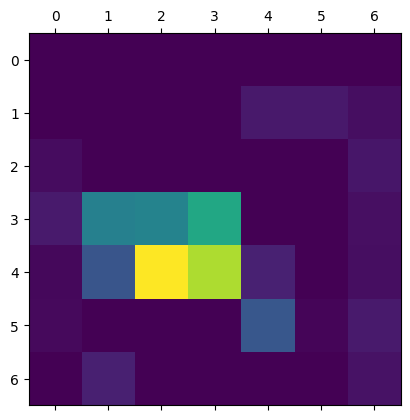

In [8]:
bluetitPath = "just-bird-data/withBackground/blueTit/(1).jpg"
# unfreeze_layers(model)
blueMap = create_heatmap(model=model, imgpath=bluetitPath, label=(torch.tensor([0])))

In [9]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

def notworkingproperly(imgpath, heatmap):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = image_transforms(img)
    # Create a figure and plot the first image
    fig, ax = plt.subplots()
    ax.axis('off') # removes the axis markers

    # First plot the original image
    ax.imshow(to_pil_image(img_tensor, mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest') #

    # Show the plot
    plt.show()

In [10]:
# from PIL import Image
from IPython.display import display, Image
def visualize_heatmap_on_top(imgpath, heatmat, filepath):
    image = cv2.imread(imgpath)
    heatmap2 = cv2.resize(heatmat.numpy(), (image.shape[0],image.shape[1]))
    heatmap2 = np.uint8(255*heatmap2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    cv2_img = np.array(image)
    open_cv_image = cv2_img[:, :, ::-1].copy()
    superimposed_img = heatmap2 * 0.9 + open_cv_image
    # cv2.imshow("bird",superimposed_img) #this just kills the kernel
    # cv2.imwrite('./map.jpg', superimposed_img)
    cv2.imwrite(filepath, superimposed_img)
    display(Image(filepath))

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


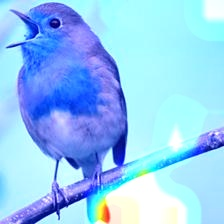

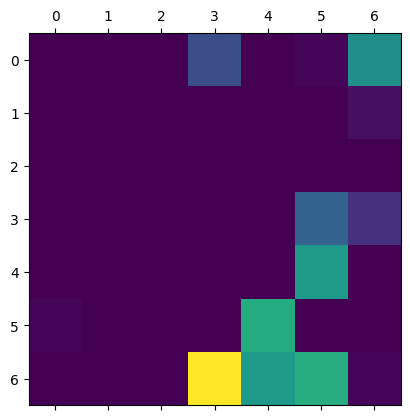

In [11]:
robinPath = "just-bird-data/withBackground/robin/(18).jpg"
# unfreeze_layers(model)
robinmat = create_heatmap(model=model, imgpath=robinPath, label=(torch.tensor([5])))
visualize_heatmap_on_top(robinPath, heatmat=robinmat, filepath="./robin.jpg")